In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from IPython.core.pylabtools import figsize
from __future__ import print_function

# import json
# import matplotlib
# s = json.load(open("../../styles/bmh_matplotlibrc.json"))
# matplotlib.rcParams.update(s)

import os
import sys
import glob
import time
import numpy as np
import numpy.random as nr

import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Input, Flatten, Dropout, Lambda
from keras.layers import Conv2D, MaxPooling2D, Embedding
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model, Sequential
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

os.makedirs('../../models',exist_ok=True)
np.set_printoptions(precision=3, linewidth=120, suppress=True)

Using TensorFlow backend.


In [2]:
import keras.backend as K
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print('X_train shape:', X_train.shape, X_train.dtype)
print('X_train min/max:', np.min(X_train), np.max(X_train))


X_train shape: (60000, 784) float32
X_train min/max: 0.0 1.0


In [29]:
def make_trainable(net, val=True):
    net.trainable = val
    for layer in net.layers:
        layer.trainable = val

M = 512
latent_dim = 100

# Generator
G_opt = Adam(lr=1e-3)
G_in = Input(shape=(latent_dim,))
G_h = Dense(M, activation='relu')(G_in)
G_h = BatchNormalization()(G_h)
G_h = Dense(M, activation='relu')(G_h)
G_h = BatchNormalization()(G_h)
G_out = Dense(784, activation='sigmoid')(G_h)
G = Model(G_in, G_out)
G.summary()
             
# Discriminator
D_opt = Adam(lr=1e-4)
D_in = Input(shape=(784,))
D_h = Dense(M, activation='relu')(D_in)
D_h = BatchNormalization()(D_h)
D_h = Dense(M, activation='relu')(D_h)
D_h = BatchNormalization()(D_h)
D_out = Dense(1, activation='sigmoid')(D_h)
D = Model(D_in, D_out)
D.compile(loss='binary_crossentropy', optimizer=D_opt, metrics=['accuracy'])
D.summary()

N_in = Input(shape=(latent_dim,))
N_img = G(N_in)
N_out = D(N_img)
GAN = Model(N_in, N_out)
GAN.compile(loss='binary_crossentropy', optimizer=G_opt, metrics=['accuracy'])
GAN.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               51712     
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
dense_15 (Dense)             (None, 784)               402192    
Total params: 720,656
Trainable params: 718,608
Non-trainable params: 2,048
_________________________________________________________________


In [30]:
def show_images(rows, cols, real, fake):
    n = rows * cols
    fake_images = fake.reshape(-1, 28, 28)[:n//2]
    real_images = real.reshape(-1, 28, 28)[:n//2]
    for i, (img_f, img_r) in enumerate(zip(fake_images, real_images)):
        plot.subplot(rows, cols, 2*i+1)
        plot.imshow(img_r, cmap=plot.cm.gray)
        plot.axis('off')    
        plot.subplot(rows, cols, 2*i+2)
        plot.imshow(img_f, cmap=plot.cm.gray)
        plot.axis('off')    

def sample_Z(m):
    return np.random.uniform(-1.0, 1.0, size=[m, latent_dim])

def sample_X(m):
    return X_train[np.random.randint(0.0, X_train.shape[0], size=m)]

Training data shapes: (2000, 784) (2000, 1)
Epoch 1/1
2000/2000 [==============================] - 0s      
Accuracy: 1.0


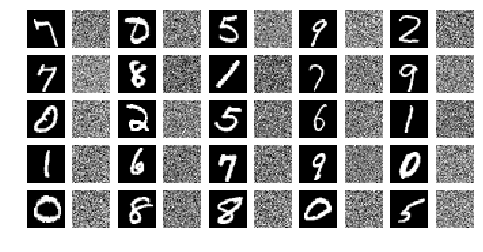

In [31]:
ntrain = 1000

# Real images
real_images = sample_X(ntrain)
real_targets = np.ones((ntrain, 1))

# Fake images
fake_images = G.predict(sample_Z(ntrain))
fake_targets = np.zeros((ntrain, 1))

figsize(8, 4)
show_images(5, 10, real_images, fake_images)

# Train discriminator these images
X = np.vstack((real_images,  fake_images))
y = np.vstack((real_targets, fake_targets))

print('Training data shapes:', X.shape, y.shape)

make_trainable(D, True)
D.fit(X, y, epochs=1, batch_size=32)

loss, acc = D.evaluate(X, y)
print('Accuracy:', acc)


In [24]:
losses = dict(g=[], d=[])

def trainIt(nepochs, batch_size=32, pint=10):
    
    t0 = time.time()
    for i in range(nepochs):
        
        # Real images
        real_images = sample_X(batch_size)
        real_targets = np.ones((batch_size, 1))
        
        # Fake images
        fake_images = G.predict(sample_Z(batch_size))
        fake_targets = np.zeros((batch_size, 1))
        
        # Train discriminator these images and targets
        # --------------------------------------------
        X = np.vstack((real_images,  fake_images))
        y = np.vstack((real_targets, fake_targets))
        
        make_trainable(D, True)
        d_loss, d_acc  = D.train_on_batch(X, y)
        losses["d"].append((d_loss, d_acc))
    
        # Train Generator-Discriminator stack on input noise
        # --------------------------------------------------
        Z = sample_Z(batch_size)
        t = np.ones([batch_size, 1])

        make_trainable(D, False)
        g_loss, g_acc = GAN.train_on_batch(Z, t)
        losses["g"].append((g_loss, g_acc))
        
        if i%pint == 0:
            print('{:6d} -- G = {:.5f}, {:.5f};  D = {:.5f}, {:.5f};  [{:.1f}s]'.format(i, 
                                                                                        g_loss, g_acc, 
                                                                                        d_loss, d_acc, 
                                                                                        time.time() - t0))
            t0 = time.time()


In [25]:
figsize(8, 8)
try:
    trainIt(10000, batch_size=32, pint=100)
    
except KeyboardInterrupt:
    pass

     0 -- G = 0.00002, 1.00000;  D = 0.00000, 1.00000;  [0.0s]
   100 -- G = 0.00002, 1.00000;  D = 0.00000, 1.00000;  [2.1s]
   200 -- G = 0.00001, 1.00000;  D = 0.00000, 1.00000;  [2.1s]
   300 -- G = 0.00001, 1.00000;  D = 0.00000, 1.00000;  [2.1s]
   400 -- G = 0.00001, 1.00000;  D = 0.00000, 1.00000;  [2.1s]
   500 -- G = 0.00001, 1.00000;  D = 0.00000, 1.00000;  [2.1s]
   600 -- G = 0.00001, 1.00000;  D = 0.00000, 1.00000;  [2.1s]
   700 -- G = 0.00001, 1.00000;  D = 0.00000, 1.00000;  [2.1s]


In [9]:
real = X_train[np.random.randint(0, X_train.shape[0], size=10)]

noise = np.random.uniform(0, 1, size=[10, 100])
fake = G.predict(noise)

y1 = GAN.predict(noise)
y2 = D.predict(fake)
y3 = D.predict(real)

print(y1.T - y2.T)
print(y2[:,0].T)
print(y3[:,0].T)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[ 0.001  0.001  0.002  0.002  0.001  0.002  0.002  0.002  0.002  0.001]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [10]:
fake_images = fake.reshape(25, 28, 28)

figsize(8, 8)
for i, img in enumerate(fake_images):
    plot.subplot(5, 5, i+1)
    plot.imshow(img, cmap=plot.cm.gray)
    plot.axis('off')    

ValueError: cannot reshape array of size 7840 into shape (25,28,28)

In [ ]:
plot.plot(losses['d'], label='D')
plot.plot(losses['g'], label='G')
plot.ylim(0, 0.1)
plot.legend()